In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from highlight_text import fig_text
from pyfonts import load_font
from pypalettes import get_hex
from utils import add_labels, get_label_rotation
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.textpath import TextPath
from matplotlib.patches import PathPatch
from matplotlib.transforms import Affine2D
from drawarrow import fig_arrow

df1 = pd.read_csv("data/employment.csv")
df1.drop(columns="disability", inplace=True)
df1["metric"] = "Employment"
df1.rename(columns={
    "count_employed": "value"
}, inplace=True)
df1_female = df1[df1["sex"]=="Female"]
df1_male = df1[df1["sex"]=="Male"]
df1 = df1_female.merge(
    df1_male,
    left_on=["island", "year", "age", "metric"],
    right_on=["island", "year", "age", "metric"],
    how="inner",
    suffixes=("_female", "_male")
)

df2 = pd.read_csv("data/education-level.csv")
df2.replace({
   "Early childhood education": "Highschool and below",
   "Primary education": "Highschool and below",
   "Lower secondary education": "Highschool and below",
   "Upper secondary education": "Highschool and below",
   "Post-secondary non-tertiary education": "After highschool",
   "Tertiary education": "After highschool"
}, inplace=True)
df2 = df2[df2["level"] == "After highschool"]
df2["metric"] = "education qualification"
df2.rename(columns={
    "count": "value"
}, inplace=True)
df2 = df2[df2["value"] < 1000]
df2_female = df2[df2["sex"]=="Female"]
df2_male = df2[df2["sex"]=="Male"]
df2 = df2_female.merge(
    df2_male,
    left_on=["island", "year", "age", "level", "metric"],
    right_on=["island", "year", "age", "level", "metric"],
    how="inner",
    suffixes=("_female", "_male")
)

df3 = pd.read_csv("data/management-position.csv")
df3.drop(columns="categories", inplace=True)
df3["metric"] = "management"
df3.rename(columns={
    "share_female_lead": "value"
}, inplace=True)
df3["value_male"] = 100 - df3["value"]
df3.rename(columns={"value": "value_female"}, inplace=True)

df = pd.concat([df1, df2, df3])
df.drop(columns=["sex_male", "sex_female", "level"], inplace=True)
df.replace("Micronesia (Federated States of)", "Micronesia", inplace=True)
df["name"] = df["island"]+" ("+df["age"]+" yo in "+df["year"].astype(str)+")"
df["name"] = ""

max_per_metric = df.groupby("metric")[["value_female", "value_male"]].max().reset_index()
max_per_metric.columns = ["metric", "max_female", "max_male"]
df = df.merge(max_per_metric, on="metric")
df["max"] = df[['max_female', 'max_female']].max(axis=1)
df["value_female_scaled"] = df["value_female"]/df["max"]*50
df["value_male_scaled"] = df["value_male"]/df["max"]*50

df["padding"] = df[["value_female_scaled", "value_male_scaled"]].max(axis=1) * 0.1
df.sort_values(by=["metric", "island", "age", "year"], inplace=True)
df.sample(10)

,island,year,value_female,age,metric,value_male,name,max_female,max_male,max,value_female_scaled,value_male_scaled,padding
55,Marshall Islands,2019,12.1,55-64,management,87.9,,54.3,92.7,54.3,11.141805,80.939227,8.093923
6,Nauru,2011,919.0,25-54,Employment,1364.0,,7856.0,11450.0,7856.0,5.849033,8.681263,0.868126
18,Marshall Islands,2021,144.0,55-64,education qualification,191.0,,886.0,671.0,886.0,8.126411,10.778781,1.077878
2,Marshall Islands,2011,3255.0,25-54,Employment,5935.0,,7856.0,11450.0,7856.0,20.716650,37.773676,3.777368
40,Vanuatu,2019,22.7,25-54,management,77.3,,54.3,92.7,54.3,20.902394,71.178637,7.117864
31,Tuvalu,2017,33.0,25-54,education qualification,174.0,,886.0,671.0,886.0,1.862302,9.819413,0.981941
56,Marshall Islands,2019,33.2,25-54,management,66.8,,54.3,92.7,54.3,30.570902,61.510129,6.151013
28,Palau,2020,365.0,55-64,education qualification,302.0,,886.0,671.0,886.0,20.598194,17.042889,2.059819
29,Tonga,2021,526.0,55-64,education qualification,671.0,,886.0,671.0,886.0,29.683973,37.866817,3.786682
17,Kiribati,2020,86.0,55-64,education qualification,137.0,,886.0,671.0,886.0,4.853273,7.731377,0.773138


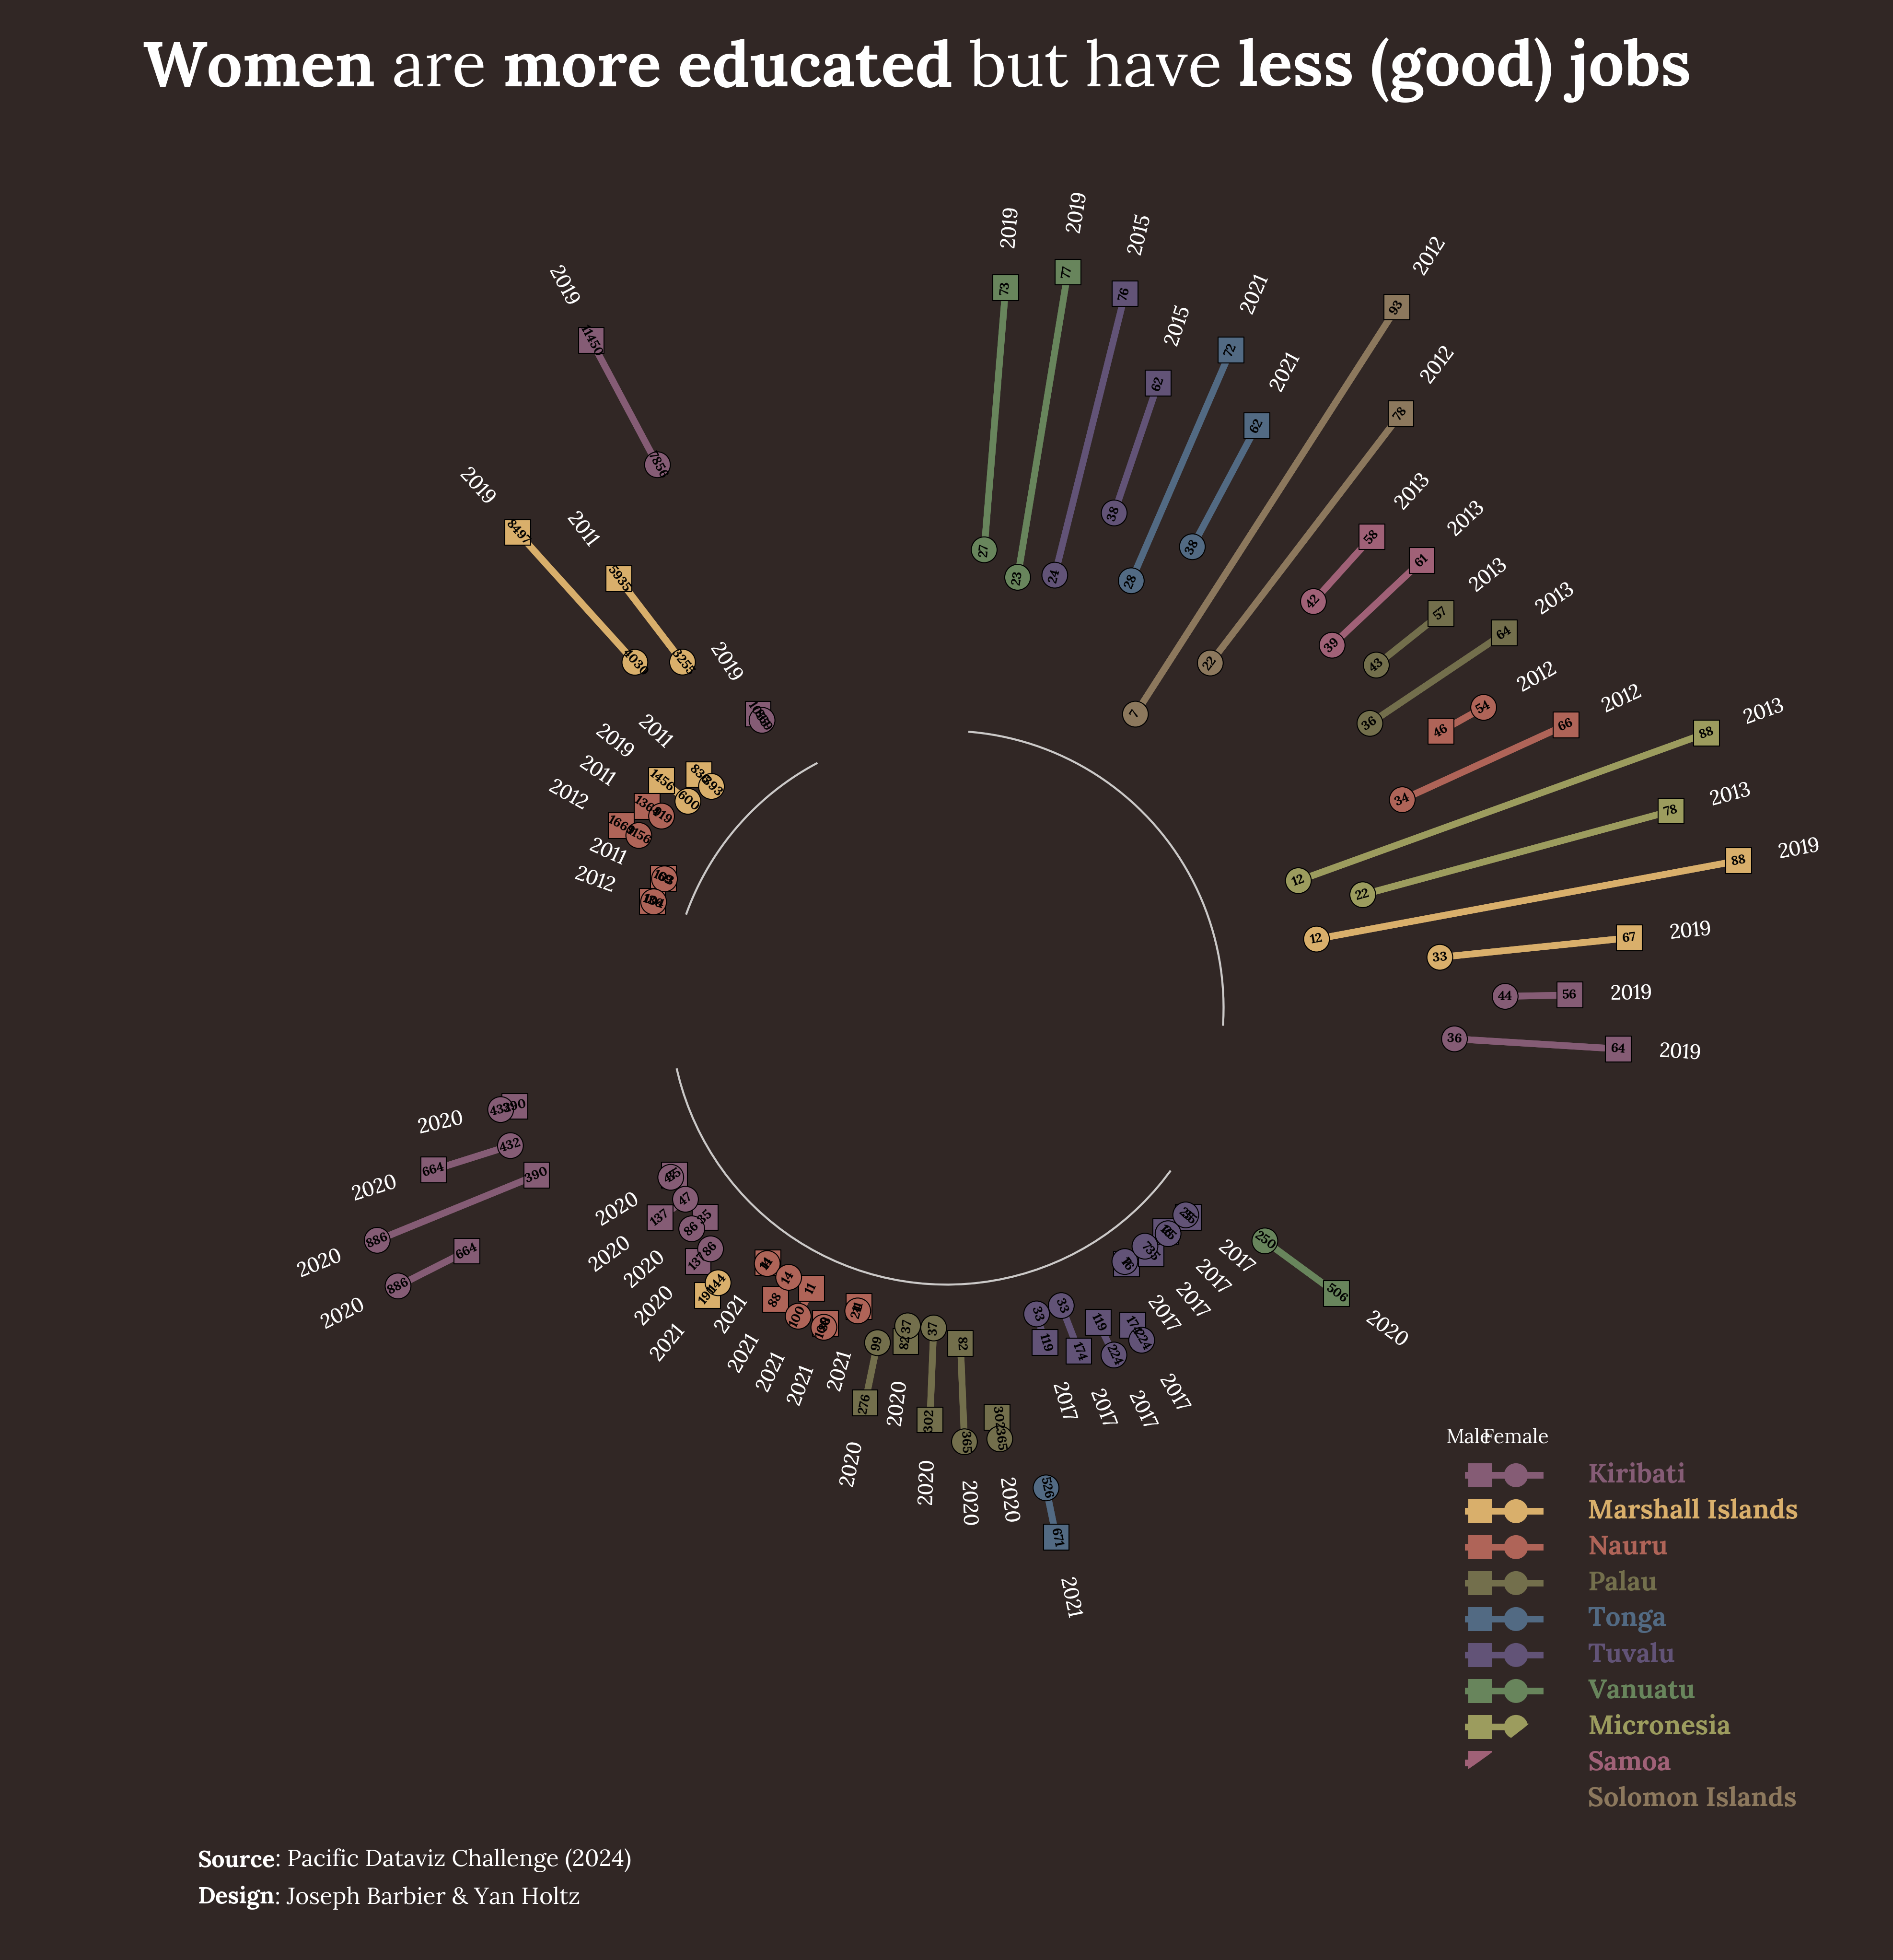

In [44]:
def get_alignement(angle, offset=0):
        if angle <= np.pi:
            alignment = 'right'
        else:
            alignment = 'left'
        return alignment

def get_label_rotation(angle):
    angle_deg = np.degrees(angle)
    rotation = (angle_deg + 90) % 360
    if 90 <= rotation < 270:
        rotation = (rotation + 180) % 360
    return rotation

def circular_lollipop(df, value, name, group, label_values, fig, ax, color_mapping, other_values, marker, year='year'):
    VALUES = df[value].values
    OTHER_VALUES = df[other_values].values
    LABELS = df[name].values
    GROUP = df[group].values
    ISLANDS = df['island'].values

    PAD = 6
    ANGLES_N = len(VALUES) + PAD * len(np.unique(GROUP))
    ANGLES = np.linspace(0, 2 * np.pi, num=ANGLES_N, endpoint=False)
    WIDTH = (2 * np.pi) / len(ANGLES)

    GROUPS_SIZE = [len(i[1]) for i in df.groupby(group)]

    offset = 0
    IDXS = []
    for size in GROUPS_SIZE:
        IDXS += list(range(offset + PAD, offset + size + PAD))
        offset += size + PAD

    ax.set_theta_offset(np.pi/2)
    ax.set_ylim(-50, 100)
    ax.set_frame_on(False)
    ax.xaxis.grid(False)
    ax.yaxis.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

    # Calculate the minimum and maximum values for each pair
    BOTTOMS = np.minimum(VALUES, OTHER_VALUES)
    TOPS = np.maximum(VALUES, OTHER_VALUES)

    # Plot lines and markers
    for angle, bottom, top, island in zip(ANGLES[IDXS], BOTTOMS, TOPS, ISLANDS):
        ax.plot(
            [angle, angle],
            [bottom, top],
            color=color_mapping[island],
            linewidth=2
        )
    scatter = ax.scatter(
        ANGLES[IDXS],
        VALUES,
        c=[color_mapping[island] for island in ISLANDS],
        s=60,
        zorder=10,
        edgecolor="black",
        linewidth=0.3,
        marker=marker
    )

    # Plot year labels and small value labels
    YEARS = df[year].values
    LABEL_VALUES = df[label_values].values
    for angle, value, other_value, year, label_value in zip(ANGLES[IDXS], VALUES, OTHER_VALUES, YEARS, LABEL_VALUES):
        alignment = get_alignement(angle, offset)
        rotation = get_label_rotation(angle)
        alignment = 'center'
        
        # Add year label
        ax.text(
            x=angle, y=max(value, other_value)+10, s=year, ha=alignment, va="center", color="white",
            font=font, fontsize=6, rotation=rotation, rotation_mode="anchor"
        )

        # Add small value label next to the current marker
        ax.text(
            x=angle, y=value, s=f"{label_value:.0f}", ha=alignment, va="center", color="black",
            font=boldfont, fontsize=4, rotation=rotation, rotation_mode="anchor", zorder=20
        )

    offset = 0 
    for group, size in zip(np.unique(GROUP), GROUPS_SIZE):
        x1 = np.linspace(ANGLES[offset + PAD], ANGLES[offset + size + PAD - 1], num=50)
        y1 = [-5] * 50  # y-coordinate for the curved line
        ax.plot(x1, y1, color=curvedline_col, alpha=0.5, linewidth=0.6)        
        offset += size + PAD

# parameters
background_col = "#312725"
curvedline_col = "white"
line_col = "#eef4ed"
annotation_color = "white"
colors = get_hex("Antique")
unique_islands = df['island'].unique()
color_mapping = dict(zip(unique_islands, colors[:len(unique_islands)]))
boldfont = load_font("https://github.com/cyrealtype/Lora-Cyrillic/blob/main/fonts/ttf/Lora-Bold.ttf?raw=true")
font = load_font("https://github.com/cyrealtype/Lora-Cyrillic/blob/main/fonts/ttf/Lora-Regular.ttf?raw=true")

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={"projection": "polar"}, dpi=500)
fig.set_facecolor(background_col)
ax.set_facecolor(background_col)

circular_lollipop(
   df=df,
   value="value_male_scaled",
   name="name",
   group="metric",
   label_values="value_male",
   fig=fig,
   ax=ax,
   color_mapping=color_mapping,
   marker="s",
   other_values="value_female_scaled"
)
circular_lollipop(
   df=df,
   value="value_female_scaled",
   name="name",
   group="metric",
   label_values="value_female",
   fig=fig,
   ax=ax,
   color_mapping=color_mapping,
   marker="o",
   other_values="value_male_scaled"
)

# title
text = "<Women> are <more educated> but have <less (good) jobs>"
fig_text(
    x=0.5, y=0.9, s=text, 
    font=font, highlight_textprops=[{'font': boldfont}]*3, color='white',
    fontsize=19, ha="center", va="top"
)

# credit
text = """
<Source>: Pacific Dataviz Challenge (2024)
<Design>: Joseph Barbier & Yan Holtz
"""
fig_text(
    x=0.2, y=0.15, s=text, 
    font=font, highlight_textprops=[{'font': boldfont}]*2, color='white',
    fontsize=7, ha="left", va="top"
)

# legend
x = 0.78
y = 0.3
line_length = 0.03
for island in df["island"].unique():
    color = color_mapping[island]
    fig_text(
        x=x, y=y, s=f"{island}", font=boldfont, color=color, fontsize=8,
        ha="left", va="center"
    )
    
    # Add square (male)
    ax.add_patch(plt.Rectangle((x-0.05, y-0.005), 0.01, 0.01, facecolor=color, transform=fig.transFigure, figure=fig))
    
    # Add circle (female)
    ax.add_patch(plt.Circle((x-0.03, y), 0.005, facecolor=color, transform=fig.transFigure, figure=fig))
    
    # Add line between shapes
    ax.plot([x, x], [y, y], color=color, linewidth=2, transform=fig.transFigure)
    
    y -= 0.015

# Add legend labels
fig_text(x=x-0.05, y=0.32, s="Male", font=font, color='white', fontsize=6, ha="center", va="top")
fig_text(x=x-0.03, y=0.32, s="Female", font=font, color='white', fontsize=6, ha="center", va="top")

plt.savefig("finalchart.png", bbox_inches="tight", dpi=500)
plt.show()